In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize, Bounds
import plotly.express as px
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm
# импортируем генераторы процессов с разными рычагами и KL метрику (в данном случае будем использовать среднее значение KL)
from leverage_functions_and_metrics import gen_e, gen_gjr, gen_poly, gen_t, gen_lin 
from leverage_functions_and_metrics import l_e, l_gjr, l_poly, l_t, KL
import time
import warnings
warnings.filterwarnings('ignore')

## Сгенерируем волатильности используя разные рычаги

In [4]:
np.random.seed(1980)
n = 1000
nu = np.random.normal(0,1, n)

# инициализируем параметры
x_e = np.array([0.2,0.3,0.1, -0.5, 0.9])
x_gjr = np.array([0.02,0.03,0.01, 0.05, 0.9])
x_poly = np.array([0.2,0.3,0.1, -0.5,0.15, 0.9])
x_t = np.array([0.2,0.3,0.1, -0.5, 0.9])
x_lin = np.array([0.218, 0.24, 0.119, 0.286, 0.225, 0.0441, -0.024, 0.012, -0.028 ,0.023, 0.045, 0.015, 0.0658, 0.9])

# сохраним волатильности
sigma_e = gen_e(x_e, nu) # рычаг из EGARCH
sigma_gjr = gen_gjr(x_gjr, nu) # рычаг из GJR - GARCH
sigma_poly = gen_poly(x_poly, nu) # полиномиальный рычаг
sigma_t = gen_t(x_t, nu) # рычаг из TGARCH
sigma_lin = gen_lin(x_lin, nu) # рычаг из линейной комбинации рычагов

In [3]:
# создадим списки с генераторами, наименованиями и начальными параметрами
gen = [gen_e, gen_gjr, gen_poly, gen_t, gen_lin]
names = ['egarch', 'gjr','poly', 'tgarch', 'lin']
x0 = [x_e, x_gjr*0.2, x_poly, x_t, x_lin]

## Приближаем EGARCH с помощью GARCH процессов с разными рычагами

In [5]:
res = {}
for i in tqdm(range(5)):
    bnds = Bounds(-1,1)
    opts = {'maxiter' : 500}#, 'verbose' : 3}  
    res1 = minimize(KL, x0=x0[i], args=(sigma_e, nu, gen[i]), method='trust-constr', bounds=bnds, options=opts)
    res[names[i]] = res1

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\Asus\Desktop\GARCH\GARCHmodels\leverage_functions_and_metrics.py:78: RuntimeWarning: overflow encountered in exp
  eps_gjr[t] = np.sqrt(np.exp(sigmalog2[t]))*nu[t]
C:\Users\Asus\Desktop\GARCH\GARCHmodels\leverage_functions_and_metrics.py:77: RuntimeWarning: invalid value encountered in double_scalars
  sigmalog2[t] = w + a*eps_gjr[t-1]**2 +theta * (eps_gjr[t-1]<0)*eps_gjr[t-1]**2 + b*sigmalog2[t-1]
C:\Users\Asus\Desktop\GARCH\GARCHmodels\leverage_functions_and_metrics.py:79: RuntimeWarning: overflow encountered in exp
  return np.sqrt(np.exp(sigmalog2))


In [6]:
# случайно сгенерируем несколько векторов значений шока
nu_ = []
for i in tqdm(range(n)):
    nu_.append(np.random.normal(0,1, n))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
# сгенерируем соответствующие шокам волатильности
s_e = []
for i in tqdm(range(n)):
    s_e.append(gen_e(x_e, nu_[i]))

  0%|          | 0/1000 [00:00<?, ?it/s]

### Соберем расстояния до полученных распределений EGARCH для всех рычагов

In [21]:
kl_arr_l = []
for i in tqdm(range(n)):
    kl_arr_l.append(KL(res['lin'].x,s_e[i],nu_[i],gen_lin))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
kl_arr_t = []
for i in tqdm(range(n)):
    kl_arr_t.append(KL(res['tgarch'].x,s_e[i],nu_[i],gen_t))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
kl_arr_e = []
for i in tqdm(range(n)):
    kl_arr_e.append(KL(res['egarch'].x,s_e[i],nu_[i],gen_e))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
kl_arr_p = []
for i in tqdm(range(n)):
    kl_arr_p.append(KL(res['poly'].x,s_e[i],nu_[i],gen_poly))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [25]:
kl_arr_g = []
for i in tqdm(range(n)):
    kl_arr_g.append(KL(res['gjr'].x,s_e[i],nu_[i],gen_gjr))

  0%|          | 0/1000 [00:00<?, ?it/s]

# Построим графики распределений KL

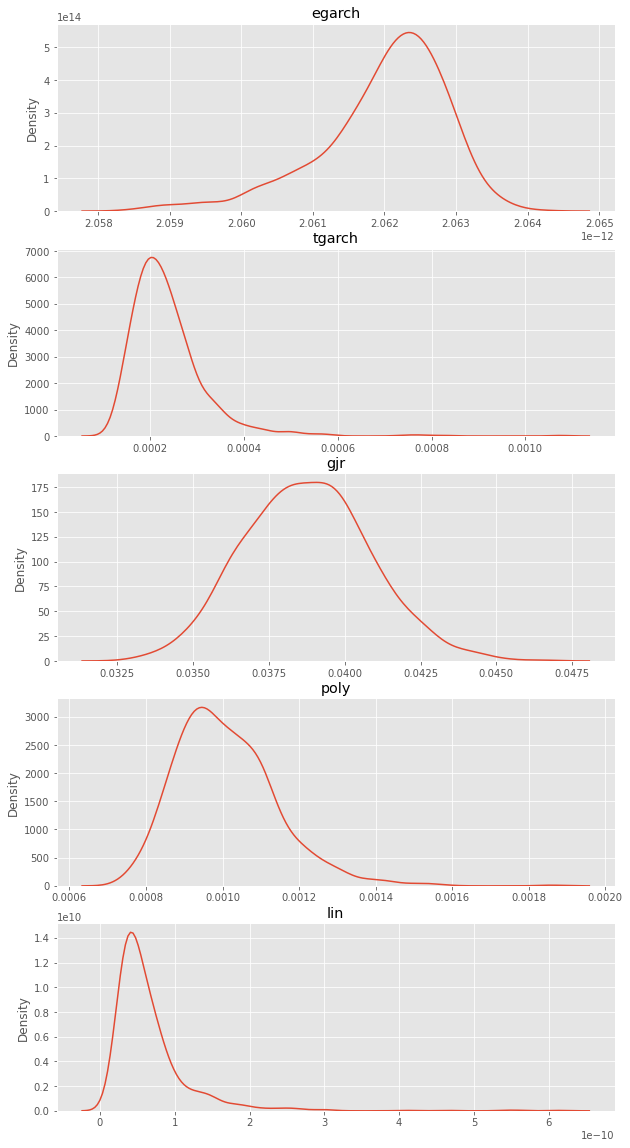

In [26]:
fig, ax = plt.subplots(5,1, figsize=(10,20))
# plt.subplots_adjust(wspace=5, hspace=5)
ax[0].set_title('egarch')
sns.kdeplot(kl_arr_e,ax=ax[0])
ax[1].set_title('tgarch')
sns.kdeplot(kl_arr_t,ax=ax[1])
ax[2].set_title('gjr')
sns.kdeplot(kl_arr_g,ax=ax[2])
ax[3].set_title('poly')
sns.kdeplot(kl_arr_p,ax=ax[3])
ax[4].set_title('lin')
sns.kdeplot(kl_arr_l,ax=ax[4])
plt.show();

In [27]:
kl_arr_l = np.array(kl_arr_l)[~np.isnan(kl_arr_l)]
kl_arr_t = np.array(kl_arr_t)[~np.isnan(kl_arr_t)]
kl_arr_e = np.array(kl_arr_e)[~np.isnan(kl_arr_e)]
kl_arr_g = np.array(kl_arr_g)[~np.isnan(kl_arr_g)]
kl_arr_p = np.array(kl_arr_p)[~np.isnan(kl_arr_p)]

In [28]:
mean = [np.mean(kl_arr_e),np.mean(kl_arr_g),np.mean(kl_arr_p),np.mean(kl_arr_t),np.mean(kl_arr_l)]


In [34]:
data = pd.DataFrame(mean, index = names, columns = ['mean'])
data['KL with original shocks'] = np.nan

In [38]:
for i in res.keys():
    data.loc[i,'KL with original shocks'] = res[i].fun

In [40]:
data.sort_values(by = 'KL with original shocks') # заметим, что при сортировке расстояния по оригинальным шокам мы
# также отсортировали и среднее значение

,mean,KL with original shocks
egarch,2.061996e-12,2.062424e-12
lin,6.666027e-11,2.427246e-11
tgarch,2.363625e-04,1.469517e-04
poly,1.009292e-03,7.803131e-04
gjr,3.876630e-02,3.678310e-02


## Приближаем TGARCH с помощью GARCH процессов с разными рычагами

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Asus\Desktop\GARCH\GARCHmodels\leverage_functions_and_metrics.py:229: RuntimeWarning: divide by zero encountered in log
  kl = -1/2 - np.log(sigma)+np.log(sigma_teta)+0.5*(sigma/sigma_teta)**2
C:\Users\Asus\Desktop\GARCH\GARCHmodels\leverage_functions_and_metrics.py:229: RuntimeWarning: divide by zero encountered in true_divide
  kl = -1/2 - np.log(sigma)+np.log(sigma_teta)+0.5*(sigma/sigma_teta)**2
C:\Users\Asus\Desktop\GARCH\GARCHmodels\leverage_functions_and_metrics.py:229: RuntimeWarning: invalid value encountered in add
  kl = -1/2 - np.log(sigma)+np.log(sigma_teta)+0.5*(sigma/sigma_teta)**2


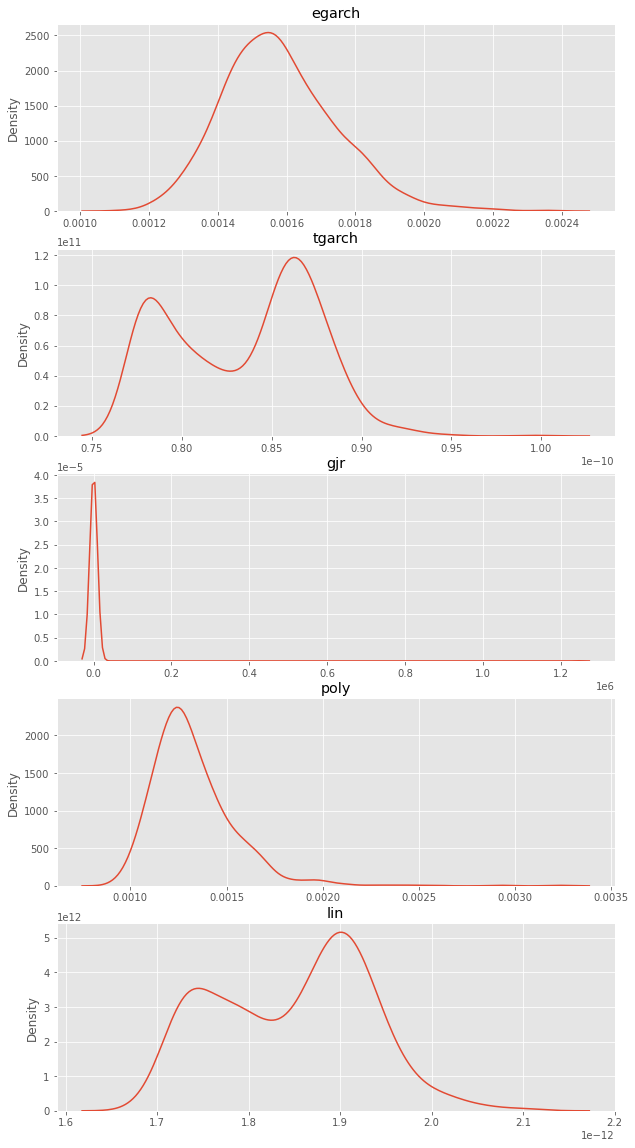

In [41]:
res = {}
for i in tqdm(range(5)):
    bnds = Bounds(-1,1)
    opts = {'maxiter' : 500}#, 'verbose' : 3}  
    res1 = minimize(KL, x0=x0[i], args=(sigma_t, nu, gen[i]), method='trust-constr', bounds=bnds, options=opts)
    res[names[i]] = res1

# случайно сгенерируем несколько векторов значений шока
nu_ = []
for i in tqdm(range(n)):
    nu_.append(np.random.normal(0,1, n))

# сгенерируем соответствующие шокам волатильности
s_t = []
for i in range(n):
    s_t.append(gen_t(x_t, nu_[i]))

### Соберем расстояния до полученных распределений TGARCH для всех рычагов

kl_arr_l = []
for i in range(n):
    kl_arr_l.append(KL(res['lin'].x,s_t[i],nu_[i],gen_lin))

kl_arr_t = []
for i in range(n):
    kl_arr_t.append(KL(res['tgarch'].x,s_t[i],nu_[i],gen_t))

kl_arr_e = []
for i in range(n):
    kl_arr_e.append(KL(res['egarch'].x,s_t[i],nu_[i],gen_e))

kl_arr_p = []
for i in range(n):
    kl_arr_p.append(KL(res['poly'].x,s_t[i],nu_[i],gen_poly))

kl_arr_g = []
for i in range(n):
    kl_arr_g.append(KL(res['gjr'].x,s_t[i],nu_[i],gen_gjr))

# Построим графики распределений KL

fig, ax = plt.subplots(5,1, figsize=(10,20))
# plt.subplots_adjust(wspace=5, hspace=5)
ax[0].set_title('egarch')
sns.kdeplot(kl_arr_e,ax=ax[0])
ax[1].set_title('tgarch')
sns.kdeplot(kl_arr_t,ax=ax[1])
ax[2].set_title('gjr')
sns.kdeplot(kl_arr_g,ax=ax[2])
ax[3].set_title('poly')
sns.kdeplot(kl_arr_p,ax=ax[3])
ax[4].set_title('lin')
sns.kdeplot(kl_arr_l,ax=ax[4])
plt.show();

In [42]:
kl_arr_l = np.array(kl_arr_l)[~np.isnan(kl_arr_l)]
kl_arr_t = np.array(kl_arr_t)[~np.isnan(kl_arr_t)]
kl_arr_e = np.array(kl_arr_e)[~np.isnan(kl_arr_e)]
kl_arr_g = np.array(kl_arr_g)[~np.isnan(kl_arr_g)]
kl_arr_p = np.array(kl_arr_p)[~np.isnan(kl_arr_p)]

mean = [np.mean(kl_arr_e),np.mean(kl_arr_g),np.mean(kl_arr_p),np.mean(kl_arr_t),np.mean(kl_arr_l)]


data = pd.DataFrame(mean, index = names, columns = ['mean'])
data['KL with original shocks'] = np.nan

for i in res.keys():
    data.loc[i,'KL with original shocks'] = res[i].fun

data.sort_values(by = 'KL with original shocks') # заметим, что при сортировке расстояния по оригинальным шокам мы
# также отсортировали и среднее значение

,mean,KL with original shocks
lin,1.847435e-12,1.720663e-12
tgarch,8.346872e-11,7.903844e-11
poly,1.324670e-03,9.822883e-04
egarch,1.579387e-03,1.365006e-03
gjr,1.245068e+03,3.505416e-03


## Приближаем GJR - GARCH с помощью GARCH процессов с разными рычагами

  0%|          | 0/5 [00:00<?, ?it/s]

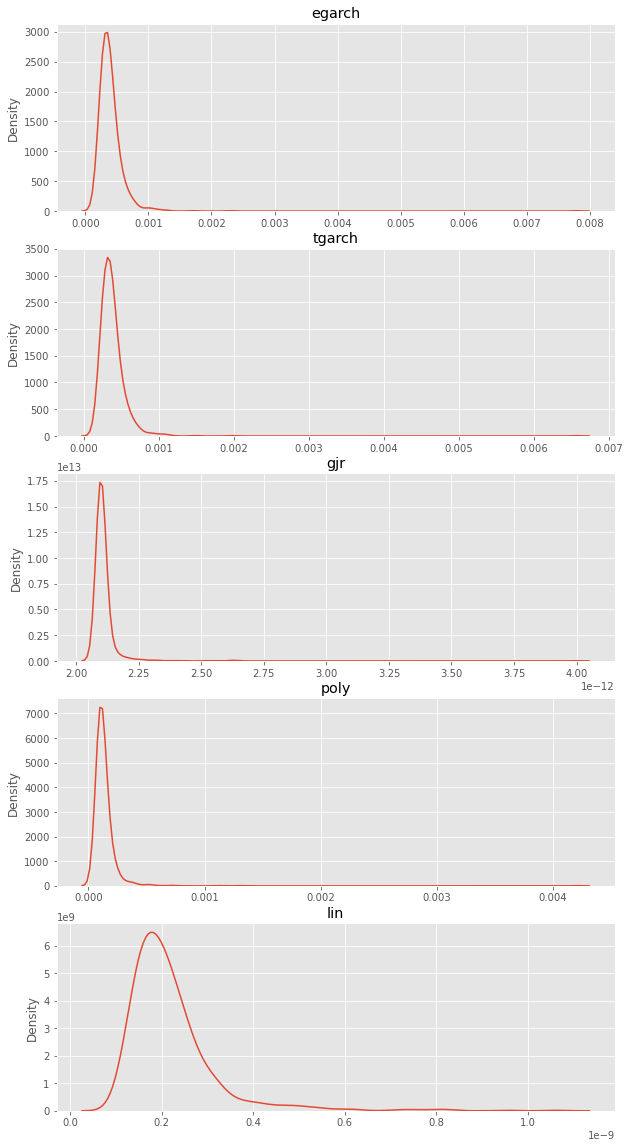

In [43]:
res = {}
for i in tqdm(range(5)):
    bnds = Bounds(-1,1)
    opts = {'maxiter' : 500}#, 'verbose' : 3}  
    res1 = minimize(KL, x0=x0[i], args=(sigma_gjr, nu, gen[i]), method='trust-constr', bounds=bnds, options=opts)
    res[names[i]] = res1

# случайно сгенерируем несколько векторов значений шока
nu_ = []
for i in range(n):
    nu_.append(np.random.normal(0,1, n))

# сгенерируем соответствующие шокам волатильности
s_gjr = []
for i in range(n):
    s_gjr.append(gen_gjr(x_gjr, nu_[i]))

### Соберем расстояния до полученных распределений GJR-GARCH для всех рычагов

kl_arr_l = []
for i in range(n):
    kl_arr_l.append(KL(res['lin'].x,s_gjr[i],nu_[i],gen_lin))

kl_arr_t = []
for i in range(n):
    kl_arr_t.append(KL(res['tgarch'].x,s_gjr[i],nu_[i],gen_t))

kl_arr_e = []
for i in range(n):
    kl_arr_e.append(KL(res['egarch'].x,s_gjr[i],nu_[i],gen_e))

kl_arr_p = []
for i in range(n):
    kl_arr_p.append(KL(res['poly'].x,s_gjr[i],nu_[i],gen_poly))

kl_arr_g = []
for i in range(n):
    kl_arr_g.append(KL(res['gjr'].x,s_gjr[i],nu_[i],gen_gjr))

# Построим графики распределений KL

fig, ax = plt.subplots(5,1, figsize=(10,20))
# plt.subplots_adjust(wspace=5, hspace=5)
ax[0].set_title('egarch')
sns.kdeplot(kl_arr_e,ax=ax[0])
ax[1].set_title('tgarch')
sns.kdeplot(kl_arr_t,ax=ax[1])
ax[2].set_title('gjr')
sns.kdeplot(kl_arr_g,ax=ax[2])
ax[3].set_title('poly')
sns.kdeplot(kl_arr_p,ax=ax[3])
ax[4].set_title('lin')
sns.kdeplot(kl_arr_l,ax=ax[4])
plt.show();

In [44]:
kl_arr_l = np.array(kl_arr_l)[~np.isnan(kl_arr_l)]
kl_arr_t = np.array(kl_arr_t)[~np.isnan(kl_arr_t)]
kl_arr_e = np.array(kl_arr_e)[~np.isnan(kl_arr_e)]
kl_arr_g = np.array(kl_arr_g)[~np.isnan(kl_arr_g)]
kl_arr_p = np.array(kl_arr_p)[~np.isnan(kl_arr_p)]

mean = [np.mean(kl_arr_e),np.mean(kl_arr_g),np.mean(kl_arr_p),np.mean(kl_arr_t),np.mean(kl_arr_l)]


data = pd.DataFrame(mean, index = names, columns = ['mean'])
data['KL with original shocks'] = np.nan

for i in res.keys():
    data.loc[i,'KL with original shocks'] = res[i].fun

data.sort_values(by = 'KL with original shocks') # заметим, что при сортировке расстояния по оригинальным шокам мы
# также отсортировали и среднее значение

,mean,KL with original shocks
gjr,2.109774e-12,2.085455e-12
lin,2.191635e-10,9.949329e-11
poly,1.378520e-04,6.434759e-05
tgarch,3.776632e-04,1.797105e-04
egarch,3.988772e-04,1.810652e-04


## Приближаем GARCH c полиномиальным рычагом с помощью GARCH процессов с разными рычагами

  0%|          | 0/5 [00:00<?, ?it/s]

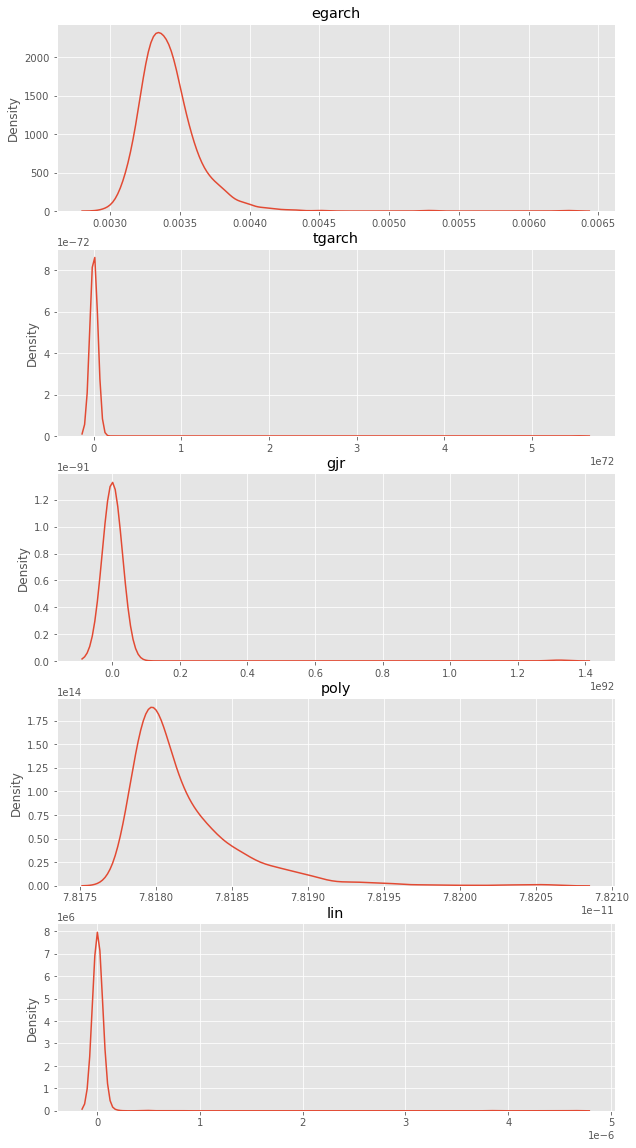

In [47]:
res = {}
for i in tqdm(range(5)):
    bnds = Bounds(-1,1)
    opts = {'maxiter' : 500}#, 'verbose' : 3}  
    res1 = minimize(KL, x0=x0[i]*0.2, args=(sigma_poly, nu, gen[i]), method='trust-constr', bounds=bnds, options=opts)
    res[names[i]] = res1

# случайно сгенерируем несколько векторов значений шока
nu_ = []
for i in range(n):
    nu_.append(np.random.normal(0,1, n))

# сгенерируем соответствующие шокам волатильности
s_poly = []
for i in range(n):
    s_poly.append(gen_poly(x_poly, nu_[i]))

### Соберем расстояния до полученных распределений GARCH  c полиномиальным рычагом для всех рычагов

kl_arr_l = []
for i in range(n):
    kl_arr_l.append(KL(res['lin'].x,s_poly[i],nu_[i],gen_lin))

kl_arr_t = []
for i in range(n):
    kl_arr_t.append(KL(res['tgarch'].x,s_poly[i],nu_[i],gen_t))

kl_arr_e = []
for i in range(n):
    kl_arr_e.append(KL(res['egarch'].x,s_poly[i],nu_[i],gen_e))

kl_arr_p = []
for i in range(n):
    kl_arr_p.append(KL(res['poly'].x,s_poly[i],nu_[i],gen_poly))

kl_arr_g = []
for i in range(n):
    kl_arr_g.append(KL(res['gjr'].x,s_poly[i],nu_[i],gen_gjr))

# Построим графики распределений KL
kl_arr_l = np.array(kl_arr_l)[~np.isnan(kl_arr_l)]
kl_arr_t = np.array(kl_arr_t)[~np.isnan(kl_arr_t)]
kl_arr_e = np.array(kl_arr_e)[~np.isnan(kl_arr_e)]
kl_arr_g = np.array(kl_arr_g)[~np.isnan(kl_arr_g)]
kl_arr_p = np.array(kl_arr_p)[~np.isnan(kl_arr_p)]
fig, ax = plt.subplots(5,1, figsize=(10,20))
# plt.subplots_adjust(wspace=5, hspace=5)
ax[0].set_title('egarch')
sns.kdeplot(kl_arr_e,ax=ax[0])
ax[1].set_title('tgarch')
sns.kdeplot(kl_arr_t,ax=ax[1])
ax[2].set_title('gjr')
sns.kdeplot(kl_arr_g,ax=ax[2])
ax[3].set_title('poly')
sns.kdeplot(kl_arr_p,ax=ax[3])
ax[4].set_title('lin')
sns.kdeplot(kl_arr_l,ax=ax[4])
plt.show();

In [48]:
mean = [np.mean(kl_arr_e),np.mean(kl_arr_g),np.mean(kl_arr_p),np.mean(kl_arr_t),np.mean(kl_arr_l)]


data = pd.DataFrame(mean, index = names, columns = ['mean'])
data['KL with original shocks'] = np.nan

for i in res.keys():
    data.loc[i,'KL with original shocks'] = res[i].fun

data.sort_values(by = 'KL with original shocks') # заметим, что при сортировке расстояния по оригинальным шокам мы
# также отсортировали и среднее значение


,mean,KL with original shocks
poly,7.818190e-11,7.818294e-11
lin,1.653505e-08,3.285009e-10
egarch,3.422165e-03,3.081593e-03
tgarch,5.721631e+69,5.224353e-03
gjr,5.876294e+89,1.711746e-02


Заметим, что при сортировке расстояния по оригинальным шокам мы также отсортировали и среднее значение для каждого из рассмотренных случаев. Отcюда вытекает следующая

__Гипотеза__: 
    
   Пусть у нас есть GARCH процесс $\varepsilon (\theta, \gamma)$ с рычагом $ g(\theta) $ и мы приблизили этот процесс с помощью GARCH  процессов $\varepsilon_1(\theta_1, \gamma_1), \varepsilon_2(\theta_2, \gamma_2),\cdots,\varepsilon_n(\theta_n, \gamma_n) $ с функциями рычага вида
   $ g_1(\theta_1), g_2(\theta_2), \cdots, g_n(\theta_n)$ при заданных шоках $\eta$ причем так, что:
   
   (1)
   
   $$KL(\varepsilon (\theta, \gamma), \varepsilon_1(\theta_1, \gamma_1), \eta)\geq KL(\varepsilon(\theta, \gamma), \varepsilon_2(\theta_2, \gamma_2),\eta) \geq \cdots \geq KL(\varepsilon(\theta, \gamma), \varepsilon_n(\theta_n, \gamma_n), \eta).$$
   
Тогда соотношение (1) в среднем не зависит от $\eta$

Отдельно стоит рассмотреть случай с GARCH процессом c рычагом, состоящим из линейной комбинации рассмотренных рычагов

## Приближаем GARCH c рычагом, состоящим из линейной комбинации рассмотренных рычагов с помощью GARCH процессов с разными рычагами

In [54]:
res = {}
for i in range(5):
    bnds = Bounds(-1,1)
    opts = {'maxiter' : 500}#, 'verbose' : 3}  
    res1 = minimize(KL, x0=x0[i]*0.2, args=(sigma_lin, nu, gen[i]), method='trust-constr', bounds=bnds, options=opts)
    res[names[i]] = res1

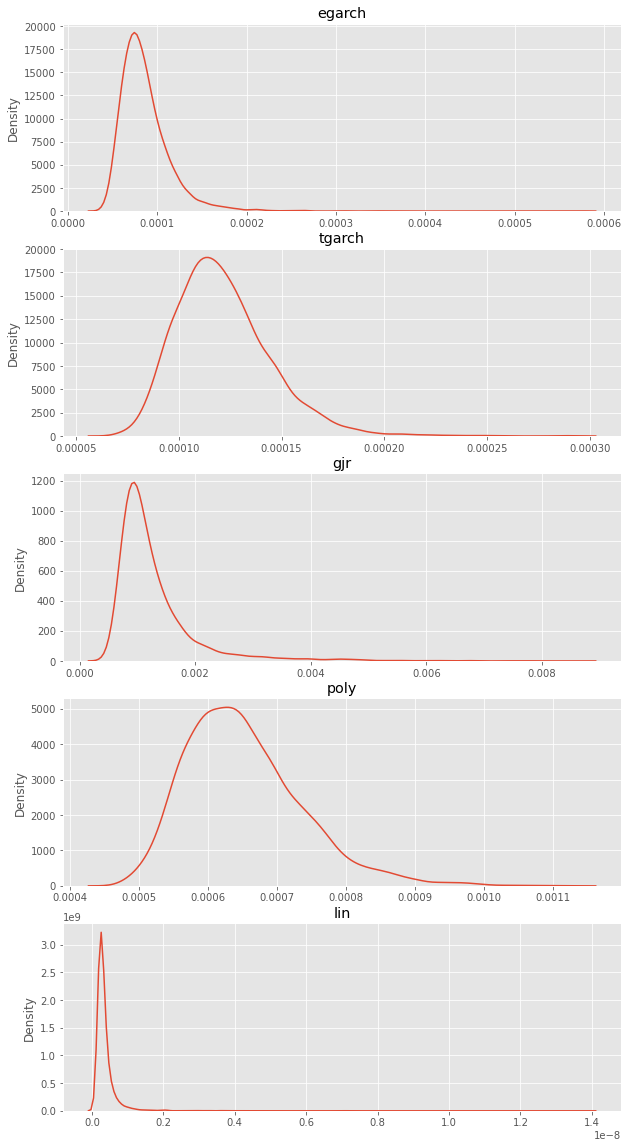

In [55]:

nu_ = []
for i in range(n+4000):
    nu_.append(np.random.normal(0,1, n))


s_lin = []
for i in range(n+4000):
    s_lin.append(gen_lin(x_lin, nu_[i]))


kl_arr_l = []
for i in range(n+4000):
    kl_arr_l.append(KL(res['lin'].x,s_lin[i],nu_[i],gen_lin))

kl_arr_t = []
for i in range(n+4000):
    kl_arr_t.append(KL(res['tgarch'].x,s_lin[i],nu_[i],gen_t))

kl_arr_e = []
for i in range(n+4000):
    kl_arr_e.append(KL(res['egarch'].x,s_lin[i],nu_[i],gen_e))

kl_arr_p = []
for i in range(n+4000):
    kl_arr_p.append(KL(res['poly'].x,s_lin[i],nu_[i],gen_poly))

kl_arr_g = []
for i in range(n+4000):
    kl_arr_g.append(KL(res['gjr'].x,s_lin[i],nu_[i],gen_gjr))

# Построим графики распределений KL
kl_arr_l = np.array(kl_arr_l)[~np.isnan(kl_arr_l)]
kl_arr_t = np.array(kl_arr_t)[~np.isnan(kl_arr_t)]
kl_arr_e = np.array(kl_arr_e)[~np.isnan(kl_arr_e)]
kl_arr_g = np.array(kl_arr_g)[~np.isnan(kl_arr_g)]
kl_arr_p = np.array(kl_arr_p)[~np.isnan(kl_arr_p)]
fig, ax = plt.subplots(5,1, figsize=(10,20))
# plt.subplots_adjust(wspace=5, hspace=5)
ax[0].set_title('egarch')
sns.kdeplot(kl_arr_e,ax=ax[0])
ax[1].set_title('tgarch')
sns.kdeplot(kl_arr_t,ax=ax[1])
ax[2].set_title('gjr')
sns.kdeplot(kl_arr_g,ax=ax[2])
ax[3].set_title('poly')
sns.kdeplot(kl_arr_p,ax=ax[3])
ax[4].set_title('lin')
sns.kdeplot(kl_arr_l,ax=ax[4])
plt.show();

In [58]:
kl_arr_p.shape,kl_arr_g.shape

((5000,), (4704,))

In [59]:
kl_arr_l.shape,kl_arr_e.shape,kl_arr_t.shape,

((5000,), (5000,), (5000,))

In [56]:
mean = [np.mean(kl_arr_e),np.mean(kl_arr_g),np.mean(kl_arr_p),np.mean(kl_arr_t),np.mean(kl_arr_l)]


data = pd.DataFrame(mean, index = names, columns = ['mean'])
data['KL with original shocks'] = np.nan

for i in res.keys():
    data.loc[i,'KL with original shocks'] = res[i].fun

data.sort_values(by = 'KL with original shocks')

,mean,KL with original shocks
lin,3.634677e-10,1.607349e-10
egarch,8.625162e-05,4.230950e-05
tgarch,1.217345e-04,8.492610e-05
gjr,1.276890e-03,5.255090e-04
poly,6.518737e-04,5.264277e-04


In [57]:
data.sort_values(by = 'mean')

,mean,KL with original shocks
lin,3.634677e-10,1.607349e-10
egarch,8.625162e-05,4.230950e-05
tgarch,1.217345e-04,8.492610e-05
poly,6.518737e-04,5.264277e-04
gjr,1.276890e-03,5.255090e-04


В данном случае можно подумать, что утверждение гипотезы нарушается, однако стоит заметить, что полученные расстояния для GARCH с полиномиальным и GJR рычагами для заданных шоков различаются на 9.187000000000561e-07, из чего следует, что в данном случае проблема может быть не в утверждении, сформулированном выше, а в процессе оптимизации.